- environment setup

In [1]:
import re
import unicodedata
import pandas as pd
import nltk

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

# Lesson

In [2]:
url = get_db_url("spam_db")
sql = "SELECT * FROM spam;"

In [3]:
df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]
## clean data

In [5]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
# quick compare of how many messages are spam vs not spam

labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


- baseline would be not spam, as 86% of messages sent are not spam

In [6]:
# create a list of words 
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [7]:
# count word frequency 
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [8]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
## create dataframe of word counts, vs how many times the word was used in spam and not spam messages

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [9]:
word_counts.sort_values(by='all', ascending=False).head(10)
# view most frequently occuring words overall

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


- Are there any words that uniquely identify a spam or ham message?
    - 'call' and 'free' show up overwhelmingly more often in spam messages
    
    - most other words are used in more often in not spam messages

In [10]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])
# see which words are only used in spam or not spam messages

,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


## Visualization

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

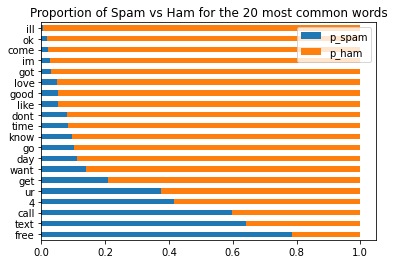

In [12]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [13]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))
# view ratios

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


## Word Clouds

- Pros

    - It’s intuitive and easy to comprehend.
    - It helps identify overall respondent sentiment and the specific factors that drive it.
    - It provides direction for further analysis.
- Cons

    - It fails to measure each word’s value in and of itself.
    - It allows irrelevant words to appear.
    - When words appear similar in size, it becomes difficult to differentiate them.

(-0.5, 399.5, 199.5, -0.5)

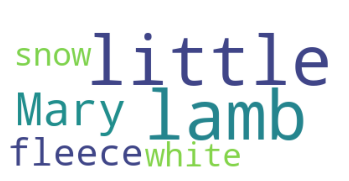

In [14]:
### Example

from wordcloud import WordCloud

sentence = 'Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow.'

img = WordCloud(background_color='white').generate(sentence)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

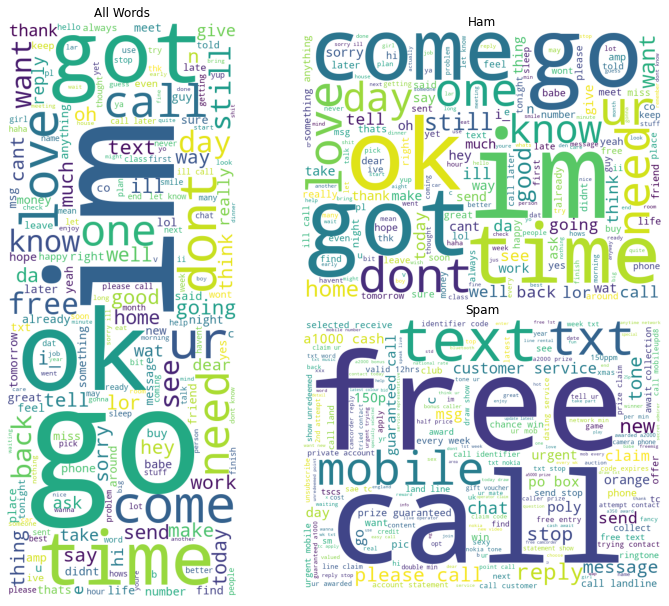

In [15]:
## make word clouds of each column

all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

### Bigrams

In [16]:
sentence = 'Mary had a little lamb'

bigrams = nltk.ngrams(sentence.split(), 2)
# create bigrams

list(bigrams)

[('Mary', 'had'), ('had', 'a'), ('a', 'little'), ('little', 'lamb')]

In [17]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      # create bigrams (nltk.ngrams(string, n_of_words))
                      .value_counts()
                      # count frequency of each bigram
                      .head(20))
                        # return only top 20

top_20_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(ok, lor)          22
(pls, send)        22
(im, gonna)        20
(happy, new)       19
(good, night)      19
(hi, hi)           18
(wat, time)        18
(last, night)      18
(great, day)       17
(send, message)    15
(nice, day)        15
dtype: int64

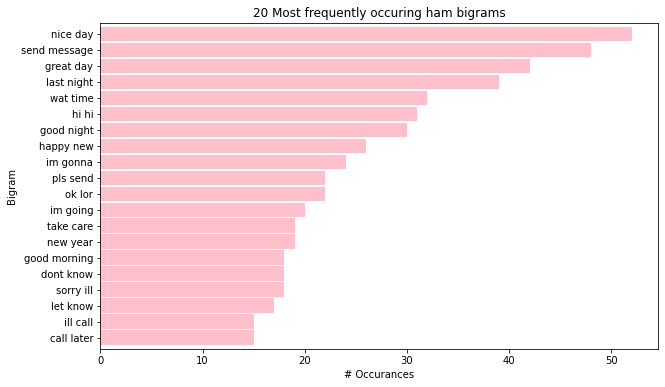

In [18]:
top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

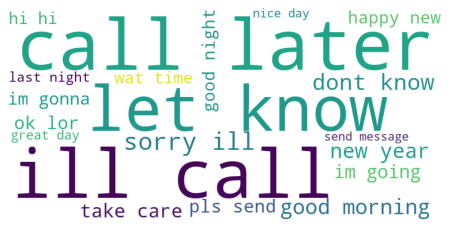

In [19]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### Trigrams

In [20]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      # create bigrams (nltk.ngrams(string, n_of_words))
                      .value_counts()
                      # count frequency of each bigram
                      .head(20))
                        # return only top 20

top_20_ham_trigrams

(ill, call, later)             42
(sorry, ill, call)             38
(happy, new, year)             19
(pls, send, message)           13
(phone, right, pls)            12
(cant, pick, phone)            12
(pick, phone, right)           12
(right, pls, send)             12
(hi, hi, hi)                   11
(x, x, x)                       8
(good, morning, dear)           7
(pls, convey, birthday)         6
(call, later, meeting)          6
(kiss, across, sea)             6
(convey, birthday, wish)        6
(story, man, last)              5
(happy, bday, bos)              5
(callertune, caller, press)     5
(good, afternoon, love)         5
(bday, wife, didnt)             5
dtype: int64

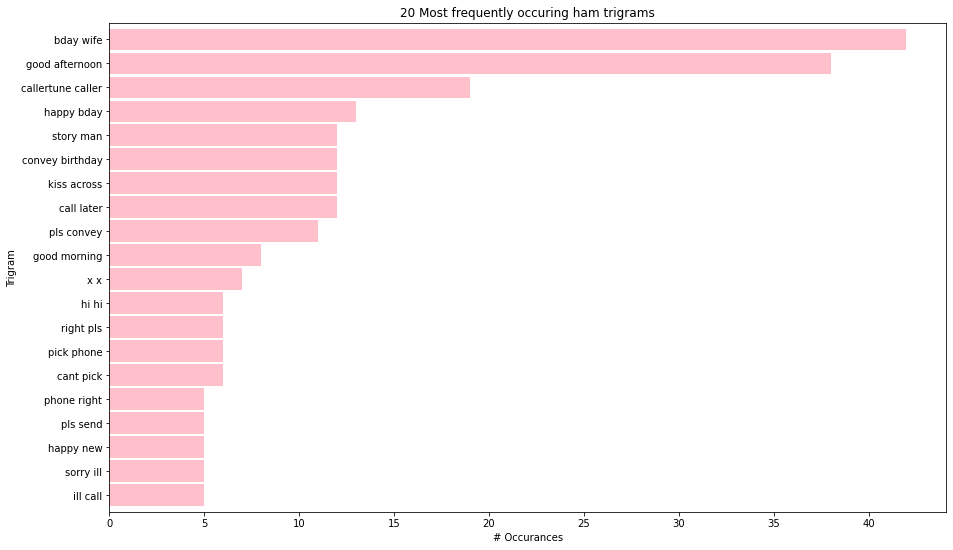

In [21]:
top_20_ham_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(15, 9))

plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

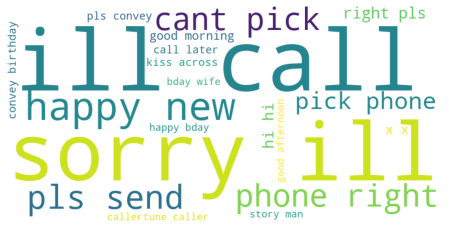

In [22]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

# Exercises

## 1. Spam Data

### A. Load the spam data set.

In [23]:
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### B. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

- bigrams

In [24]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      # create bigrams (nltk.ngrams(string, n_of_words))
                      .value_counts()
                      # count frequency of each bigram
                      .head(20))
                        # return only top 20

top_20_spam_bigrams

(please, call)          44
(customer, service)     27
(po, box)               24
(guaranteed, call)      23
(a1000, cash)           23
(prize, guaranteed)     22
(every, week)           19
(send, stop)            19
(chance, win)           19
(selected, receive)     19
(await, collection)     19
(urgent, mobile)        18
(land, line)            18
(claim, call)           17
(valid, 12hrs)          17
(prize, claim)          16
(sae, tc)               16
(call, 08000930705)     16
(account, statement)    16
(reply, call)           15
dtype: int64

In [25]:
top_20_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(ok, lor)          22
(pls, send)        22
(im, gonna)        20
(happy, new)       19
(good, night)      19
(hi, hi)           18
(wat, time)        18
(last, night)      18
(great, day)       17
(send, message)    15
(nice, day)        15
dtype: int64

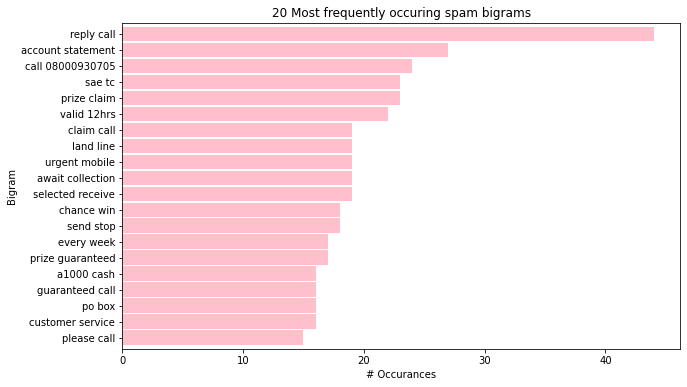

In [26]:
top_20_spam_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

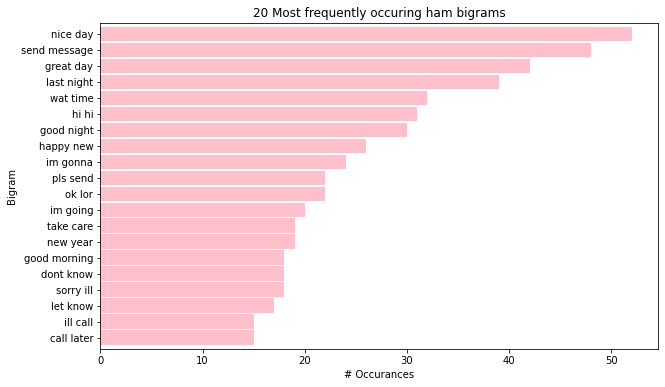

In [27]:
top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

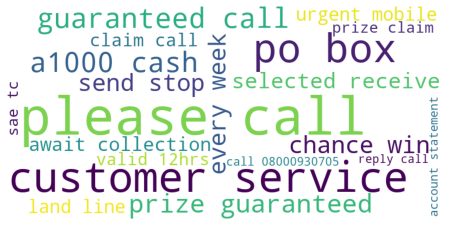

In [28]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

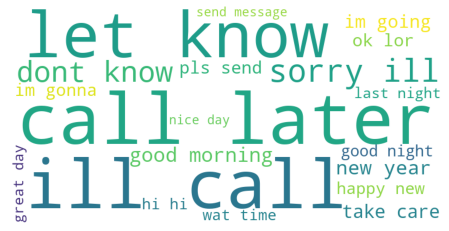

In [29]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

- trigrams

In [30]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      # create bigrams (nltk.ngrams(string, n_of_words))
                      .value_counts()
                      # count frequency of each bigram
                      .head(20))
                        # return only top 20

top_20_spam_trigrams

(prize, guaranteed, call)              21
(call, customer, service)              15
(land, line, claim)                    14
(reply, call, 08000930705)             14
(private, 2003, account)               13
(2003, account, statement)             13
(show, 800, unredeemed)                12
(camcorder, reply, call)               12
(guaranteed, a1000, cash)              12
(please, call, customer)               11
(anytime, network, min)                11
(every, week, txt)                     11
(urgent, trying, contact)              11
(bonus, caller, prize)                 11
(tone, 4, ur)                          11
(cash, await, collection)              10
(speak, live, operator)                10
(customer, service, representative)    10
(a2000, bonus, caller)                 10
(trying, contact, today)                9
dtype: int64

In [31]:
top_20_ham_trigrams

(ill, call, later)             42
(sorry, ill, call)             38
(happy, new, year)             19
(pls, send, message)           13
(phone, right, pls)            12
(cant, pick, phone)            12
(pick, phone, right)           12
(right, pls, send)             12
(hi, hi, hi)                   11
(x, x, x)                       8
(good, morning, dear)           7
(pls, convey, birthday)         6
(call, later, meeting)          6
(kiss, across, sea)             6
(convey, birthday, wish)        6
(story, man, last)              5
(happy, bday, bos)              5
(callertune, caller, press)     5
(good, afternoon, love)         5
(bday, wife, didnt)             5
dtype: int64

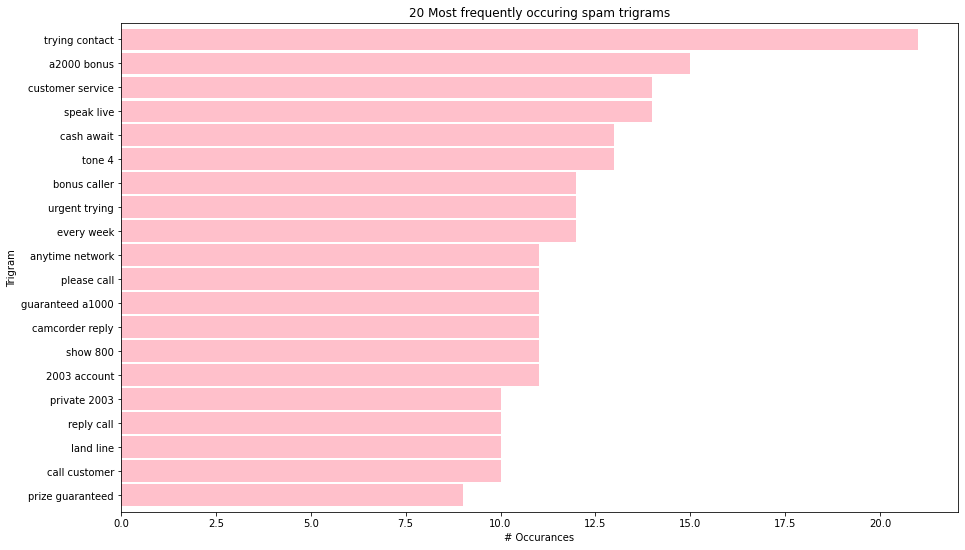

In [32]:
top_20_spam_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(15, 9))

plt.title('20 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

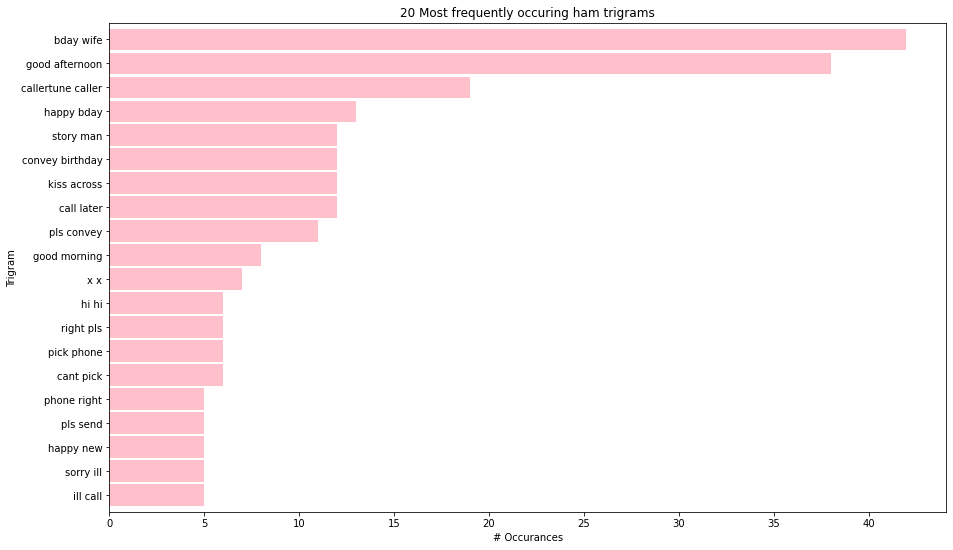

In [33]:
top_20_ham_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(15, 9))

plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

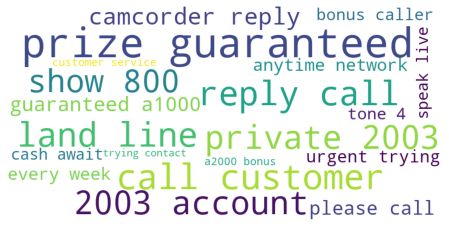

In [34]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

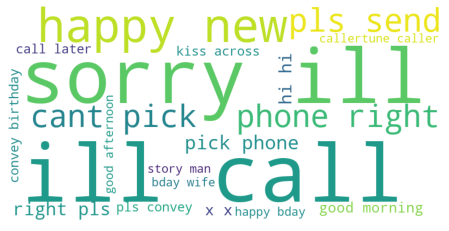

In [35]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### C. Is there any overlap in the bigrams for the spam data and the ham data?

In [36]:
# create series of spam bigrams
spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2)))

# create series of ham bigrams
ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2)))



In [37]:
# create series of all bigrams
all_bigrams = (pd.Series(nltk.ngrams(all_words, 2)))

In [38]:
ham_bigram_freq = pd.Series(ham_bigrams).value_counts()
spam_bigram_freq = pd.Series(spam_bigrams).value_counts()
## create value counts

In [39]:
all_bigram_freq = pd.Series(all_bigrams).value_counts()

In [40]:
ham_bigram_freq.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

In [41]:
spam_bigram_freq.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(guaranteed, call)     23
(a1000, cash)          23
dtype: int64

In [42]:
all_bigram_freq.head()

(please, call)    53
(call, later)     52
(ill, call)       48
(let, know)       42
(sorry, ill)      39
dtype: int64

In [43]:
bigram_counts = (pd.concat([all_bigram_freq, ham_bigram_freq, spam_bigram_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

bigram_counts.head()

all  ham  spam
0            game       2    0     2
             key        1    0     1
008704050406 sp         2    0     2
0089my       last       1    0     1
0121         2025050    1    0     1

In [44]:
bigram_counts.sort_values(by='all', ascending=False).head(10)

,,all,ham,spam
please,call,53,9,44
call,later,52,52,0
ill,call,48,48,0
let,know,42,42,0
sorry,ill,39,39,0
dont,know,38,32,6
new,year,32,30,2
good,morning,31,31,0
customer,service,29,2,27
take,care,26,26,0


- few, but not many bigrams overlap

### D. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [45]:
# create series of spam trigrams
spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3)))

# create series of ham trigrams
ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3)))

# create series of all trigrams
all_trigrams = (pd.Series(nltk.ngrams(all_words, 3)))

In [46]:
ham_trigram_freq = pd.Series(ham_trigrams).value_counts()
spam_trigram_freq = pd.Series(spam_trigrams).value_counts()
all_trigram_freq = pd.Series(all_trigrams).value_counts()
## create value counts

In [47]:
ham_trigram_freq.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(phone, right, pls)     12
dtype: int64

In [48]:
spam_trigram_freq.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
dtype: int64

In [49]:
all_trigram_freq.head()

(ill, call, later)           42
(sorry, ill, call)           38
(prize, guaranteed, call)    21
(happy, new, year)           19
(call, customer, service)    15
dtype: int64

In [50]:
trigram_counts = (pd.concat([all_trigram_freq, ham_trigram_freq, spam_trigram_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

trigram_counts.head()

all  ham  spam
0            game arcade    2    0     2
             key  arcade    1    0     1
008704050406 sp   arrow     1    0     1
                  week      1    0     1
0089my       last four      1    0     1

In [51]:
trigram_counts.sort_values(by='all', ascending=False).head(10)

,,,all,ham,spam
ill,call,later,42,42,0
sorry,ill,call,38,38,0
prize,guaranteed,call,21,0,21
happy,new,year,19,19,0
call,customer,service,15,0,15
reply,call,08000930705,14,0,14
land,line,claim,14,0,14
private,2003,account,13,0,13
2003,account,statement,13,0,13
pls,send,message,13,13,0


- there does not appear to be any overlap in trigrams

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [52]:
import acquire
import prepare

In [53]:
from acquire import get_blog_articles

In [54]:
url_list = ['https://codeup.com/codeups-data-science-career-accelerator-is-here/',
'https://codeup.com/data-science-myths/',
'https://codeup.com/data-science-vs-data-analytics-whats-the-difference/',
'https://codeup.com/10-tips-to-crush-it-at-the-sa-tech-job-fair/',
'https://codeup.com/competitor-bootcamps-are-closing-is-the-model-in-danger/']

In [55]:
codeup_df = get_blog_articles(url_list)

/Users/john/codeup-data-science/natural-language-processing-exercises/acquire.py:56: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 56 of the file /Users/john/codeup-data-science/natural-language-processing-exercises/acquire.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


In [56]:
## rename column

codeup_df = codeup_df.rename(columns = {'content' : 'original'})

#codeup_df

In [57]:
append_stopword = []

append_stopword = []

In [58]:
## make clean columns

codeup_df['clean'] = pd.Series([prepare.basic_clean(string) for string in codeup_df.original])

codeup_df['clean'] = pd.Series([prepare.tokenize(string) for string in codeup_df.clean])

codeup_df['clean'] = pd.Series([prepare.remove_stopwords(string, append_stopword, append_stopword) for string in codeup_df.clean])

#codeup_df.head()

In [59]:
## make stemmed column

codeup_df['stemmed'] = pd.Series([prepare.stem(string) for string in codeup_df.clean])

#codeup_df

In [60]:
## make lemmatize column

codeup_df['lemmatize'] = pd.Series([prepare.lemmatize(string) for string in codeup_df.clean])

codeup_df

,title,published_date,blog_image,original,clean,stemmed,lemmatize
0,Codeup’s Data Science Career Accelerator is Here!,"September 30, 2018",https://codeup.com/wp-content/uploads/2018/10/...,The rumors are true! The time has arrived. Cod...,rumors true time arrived codeup officially ope...,rumor true time arriv codeup offici open appli...,rumor true time arrived codeup officially open...
1,Data Science Myths,"October 31, 2018",https://codeup.com/wp-content/uploads/2018/10/...,By Dimitri Antoniou and Maggie Giust\nData Sci...,dimitri antoniou maggie giust data science big...,dimitri antoni maggi giust data scienc big dat...,dimitri antoniou maggie giust data science big...
2,Data Science VS Data Analytics: What’s The Dif...,"October 17, 2018",https://codeup.com/wp-content/uploads/2018/10/...,"By Dimitri Antoniou\nA week ago, Codeup launch...",dimitri antoniou week ago codeup launched imme...,dimitri antoni week ago codeup launch immers d...,dimitri antoniou week ago codeup launched imme...
3,10 Tips to Crush It at the SA Tech Job Fair,"August 14, 2018",None,SA Tech Job Fair\nThe third bi-annual San Anto...,sa tech job fair third biannual san antonio te...,sa tech job fair third biannual san antonio te...,sa tech job fair third biannual san antonio te...
4,Competitor Bootcamps Are Closing. Is the Model...,"August 14, 2018",None,Competitor Bootcamps Are Closing. Is the Model...,competitor bootcamps closing model danger prog...,competitor bootcamp close model danger program...,competitor bootcamps closing model danger prog...
